### CS182 project - Deliver ideas of CGCNN

In [1]:
### General Explanation

### Embedding Crystal Graph

In [2]:
# Note: Need pymatgen
# TODO:Explain about Crystal Graph

In [1]:
import os
import sys
import csv
import json
import torch
import torch.nn as nn
import random
import warnings
warnings.filterwarnings('ignore')
import functools
import numpy as np

from pymatgen.core.structure import Structure
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR

from data_utils import CIFData
from data_utils import AtomCustomJSONInitializer
from data_utils import AtomInitializer
from data_utils import GaussianDistance

In [6]:
# Let's convert salt (NaCl) to crystal graph.
# You can use print method to see the lattice and position of Na, Cl
# Atoms in the cell.
nacl = Structure.from_file('hw_data/cifs/1000041.cif')
print(nacl)

Full Formula (Na4 Cl4)
Reduced Formula: NaCl
abc   :   5.620000   5.620000   5.620000
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (8)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Na+   0    0    0
  1  Na+   0    0.5  0.5
  2  Na+   0.5  0    0.5
  3  Na+   0.5  0.5  0
  4  Cl-   0.5  0.5  0.5
  5  Cl-   0.5  0    0
  6  Cl-   0    0.5  0
  7  Cl-   0    0    0.5


In [7]:
# add visualization of the structure using the CIF file 

In [9]:
# First we will convert atoms to atomistic features using
# pre-difined atom embedding.
# atom_init.json is containing vector embedding of atoms,
# Where key (1, 2, 3, ..., 100) represent atomic number
# and values are embedding vectors.
# You can try different atom embedding too.

# Load embedding file.
element_embedding_file = 'hw_data/atom_init.json'
with open(element_embedding_file) as f:
    elem_embedding = json.load(f)
elem_embedding = {int(key): value for key, value
                  in elem_embedding.items()}

# Encode crsytal data to atomistic features.
# Atom_feature shd have shape of (# of atoms, len(embedding vector))
atom_fea = np.vstack([elem_embedding[nacl[i].specie.number]
                      for i in range(len(nacl))])
atom_fea = torch.Tensor(atom_fea)

assert atom_fea.shape == (8,92)

In [10]:
# Next, we will get neighbor information from each atoms in the cell.
# We will get help from pymatgen package.
# get_all_neighbor function of structure object returns atoms within
# the input radius. Note that here len(all_nbrs) is 8 since there are
# 8 atoms (4 Na+, 4 Cl-) in the cell. Each list contain the neighbor
# atom information considering periodicity.
# We will use 12 nearest neighbors after sorting with distance.

all_nbrs = nacl.get_all_neighbors(r = 8, include_index=True)
all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]

assert len(all_nbrs) == 8

nbr_fea_idx, nbr_fea = [], []
for nbr in all_nbrs:
    # Note: x[1] returns distance to neighbors.
    # Note: x[2] returns index of original structure object
    nbr_fea_idx.append(list(map(lambda x: x[2],
                                nbr[:12])))
    nbr_fea.append(list(map(lambda x: x[1],
                            nbr[:12])))

# nbr_fea_idx contain information of nearest neighbor atoms 
# from ith row (ith atom in the cell)
# For example, 0th atom (Na+ (0.0000, 0.0000, 0.0000)) is neighbored
# with 5th, 6th, 7th, etc...
# nbr_fea contain information of nearest neighbot distance.
nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
nbr_fea_idx = torch.LongTensor(nbr_fea_idx)

nbr_fea_idx_standard = torch.LongTensor([[5, 6, 7, 7, 6, 5, 2, 1, 2, 1, 3, 3],
                                         [4, 7, 6, 7, 6, 4, 2, 0, 3, 2, 3, 3],
                                         [4, 7, 5, 7, 5, 4, 0, 3, 1, 3, 3, 1],
                                         [4, 6, 5, 6, 5, 4, 2, 1, 1, 2, 0, 0],
                                         [3, 1, 2, 3, 2, 1, 6, 5, 6, 5, 7, 7],
                                         [2, 3, 0, 3, 0, 2, 4, 4, 6, 6, 4, 7],
                                         [1, 3, 0, 3, 0, 1, 4, 4, 5, 5, 5, 4],
                                         [2, 1, 0, 2, 1, 0, 4, 5, 5, 4, 6, 6]])

assert torch.equal(nbr_fea_idx, nbr_fea_idx_standard)

In [11]:
# Now we have two features, atomic feature and neighbor feature.
# Note that neighbor feature is discontionous information with respect to the distanc.
# Therefore we will expand neighbor feature using Gaussian Kernel (or Gaussian filter)
# https://en.wikipedia.org/wiki/Gaussian_filter
dmin = 0
dmax = 12
step = 0.2
var = step
filter_step = np.arange(dmin, dmax+step, step)

def expand(distances):
    # Ask student to do this
    return np.exp(-(distances[..., np.newaxis] - filter_step)**2 / var**2)

nbr_fea_gaussian = expand(nbr_fea)

In [12]:
assert np.array_equal(nbr_fea_gaussian, nbr_fea)

AssertionError: 

In [13]:
gdf = GaussianDistance(dmin=0, dmax=12, step=0.2)
nbr_fea = gdf.expand(nbr_fea)

In [14]:
# Will not be used
data_dir = './cgcnn_data/sample-regression'
test = CIFData(data_dir)
(atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = test[-1]

In [15]:
# Will not be used
structures, _, _ = test[-1]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

### Build a Model

In [16]:
# TODO: Graphics of layers

In [2]:
from model import CrystalGraphConvNet

In [18]:
# Simple test
# Set seed using manual_seed
# TODO explanation about crystal_atom_idx
torch.manual_seed(123)
crystal_atom_idx = [torch.Tensor([0, 1, 2, 3, 4, 5, 6, 7]).long()]
model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len)
model.forward(atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx)

tensor([[0.6627]], grad_fn=<AddmmBackward0>)

### Training

In [3]:
from data_utils import collate_pool, get_train_val_test_loader
from train_utils import Normalizer, train, validate, save_checkpoint
from model import CrystalGraphConvNet
from random import sample

In [4]:
torch.manual_seed(123)

# set parameters
data_dir = './hw_data/perovskite_energy'
batch_size = 8
train_ratio, val_ratio, test_ratio = 0.8, 0.1, 0.1

# get dataset

dataset = CIFData(data_dir)
collate_fn = collate_pool
train_loader, val_loader, test_loader = get_train_val_test_loader(
    dataset=dataset,
    collate_fn=collate_fn,
    batch_size=batch_size,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    test_ratio=test_ratio,
    return_test=True)

In [5]:
# normalize target

if len(dataset) < 500:
    warnings.warn('Dataset has less than 500 data points. '
                    'Lower accuracy is expected. ')
    sample_data_list = [dataset[i] for i in range(len(dataset))]
else:
    sample_data_list = [dataset[i] for i in
                        sample(range(len(dataset)), 500)]
_, sample_target, _ = collate_pool(sample_data_list)
normalizer = Normalizer(sample_target)

In [6]:
# build model
structures, _, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]

# number of hidden atom features in conv layers
atom_fea_len = 64
# number of hidden features after pooling
h_fea_len = 128
# number of conv layers
n_conv = 3
# number of hidden layers after pooling
n_h = 1

model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len=atom_fea_len,
                            n_conv=n_conv,
                            h_fea_len=h_fea_len,
                            n_h=n_h)

In [11]:
# set hyperparameters
epochs = 15
criterion = nn.MSELoss()
lr = 0.01
momentum = 0.9
weight_decay = 0

optimizer = optim.SGD(model.parameters(), lr,
                              momentum=momentum,
                              weight_decay=weight_decay)

# optimizer = optim.Adam(model.parameters(), lr,
#                         weight_decay=weight_decay)
lr_milestones = [100]
scheduler = MultiStepLR(optimizer, milestones=lr_milestones,
                            gamma=0.1)

In [12]:
running_record = {'train_loss': [], 'train_mae': [],
                    'val_loss': [], 'val_mae': []}

for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)
    
    best_mae_error = 1e10
    # train for one epoch
    # TO-Do, add tqdm in the train method, don't print too much here
    # To-Do, fix warning
    train_loss, train_mae = train(train_loader, model, criterion, optimizer, epoch, normalizer)

    # evaluate on validation set
    val_loss, val_mae = validate(val_loader, model, criterion, normalizer)

    # append loss and mae to running record. Convert tensor to float if necessary
    running_record['train_loss'].append(train_loss)
    running_record['train_mae'].append(train_mae)
    running_record['val_loss'].append(val_loss)
    running_record['val_mae'].append(val_mae)


    if val_mae != val_mae:
        print('Exit due to NaN')
        sys.exit(1)

    scheduler.step()

    # remember the best mae_eror and save checkpoint
    is_best = val_mae < best_mae_error
    best_mae_error = min(val_mae, best_mae_error)

    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_mae_error': best_mae_error,
        'optimizer': optimizer.state_dict(),
        'normalizer': normalizer.state_dict(),
    }, is_best)


Epoch 0/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.73it/s]


Train: 	Time 0.193	Data 0.166	Loss 0.6394	MAE 39.629


100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


Test: 	Time 0.580	Loss 0.5138	MAE 38.865
Epoch 1/14
----------


100%|██████████| 67/67 [00:19<00:00,  3.46it/s]


Train: 	Time 0.214	Data 0.183	Loss 0.5915	MAE 37.202


100%|██████████| 9/9 [00:10<00:00,  1.13s/it]


Test: 	Time 0.573	Loss 0.4461	MAE 35.638
Epoch 2/14
----------


100%|██████████| 67/67 [00:18<00:00,  3.69it/s]


Train: 	Time 0.196	Data 0.169	Loss 0.5706	MAE 36.429


100%|██████████| 9/9 [00:10<00:00,  1.14s/it]


Test: 	Time 0.586	Loss 0.4993	MAE 37.856
Epoch 3/14
----------


100%|██████████| 67/67 [00:18<00:00,  3.64it/s]


Train: 	Time 0.200	Data 0.171	Loss 0.5680	MAE 36.047


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Test: 	Time 0.545	Loss 0.5118	MAE 45.265
Epoch 4/14
----------


100%|██████████| 67/67 [00:19<00:00,  3.48it/s]


Train: 	Time 0.213	Data 0.183	Loss 0.5410	MAE 36.072


100%|██████████| 9/9 [00:10<00:00,  1.20s/it]


Test: 	Time 0.649	Loss 0.4967	MAE 44.712
Epoch 5/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.73it/s]


Train: 	Time 0.194	Data 0.169	Loss 0.4616	MAE 32.587


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


Test: 	Time 0.510	Loss 0.6322	MAE 44.077
Epoch 6/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.94it/s]


Train: 	Time 0.179	Data 0.154	Loss 0.4925	MAE 34.891


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Test: 	Time 0.507	Loss 0.4949	MAE 34.464
Epoch 7/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.91it/s]


Train: 	Time 0.181	Data 0.155	Loss 0.5204	MAE 33.262


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Test: 	Time 0.506	Loss 0.5030	MAE 41.835
Epoch 8/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.82it/s]


Train: 	Time 0.187	Data 0.162	Loss 0.5663	MAE 39.939


100%|██████████| 9/9 [00:09<00:00,  1.06s/it]


Test: 	Time 0.506	Loss 0.3824	MAE 35.160
Epoch 9/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.83it/s]


Train: 	Time 0.186	Data 0.161	Loss 0.4509	MAE 33.169


100%|██████████| 9/9 [00:09<00:00,  1.09s/it]


Test: 	Time 0.531	Loss 0.4434	MAE 34.837
Epoch 10/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.91it/s]


Train: 	Time 0.181	Data 0.156	Loss 0.4980	MAE 33.344


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


Test: 	Time 0.521	Loss 0.9031	MAE 53.225
Epoch 11/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.93it/s]


Train: 	Time 0.180	Data 0.155	Loss 0.4193	MAE 33.332


100%|██████████| 9/9 [00:09<00:00,  1.07s/it]


Test: 	Time 0.516	Loss 0.4570	MAE 36.706
Epoch 12/14
----------


100%|██████████| 67/67 [00:16<00:00,  3.95it/s]


Train: 	Time 0.178	Data 0.154	Loss 0.3979	MAE 30.368


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]


Test: 	Time 0.527	Loss 0.5075	MAE 36.605
Epoch 13/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.88it/s]


Train: 	Time 0.183	Data 0.157	Loss 0.4811	MAE 34.109


100%|██████████| 9/9 [00:09<00:00,  1.10s/it]


Test: 	Time 0.540	Loss 0.3802	MAE 29.961
Epoch 14/14
----------


100%|██████████| 67/67 [00:17<00:00,  3.90it/s]


Train: 	Time 0.182	Data 0.156	Loss 0.3852	MAE 30.432


100%|██████████| 9/9 [00:09<00:00,  1.08s/it]

Test: 	Time 0.526	Loss 0.6753	MAE 46.589


In [13]:
# test best model
print('---------Evaluate Model on Test Set---------------')
best_checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(best_checkpoint['state_dict'])
_, l=validate(test_loader, model, criterion, normalizer, test=True)

---------Evaluate Model on Test Set---------------


100%|██████████| 9/9 [00:11<00:00,  1.30s/it]

Test: 	Time 0.749	Loss 2.3274	MAE 64.893


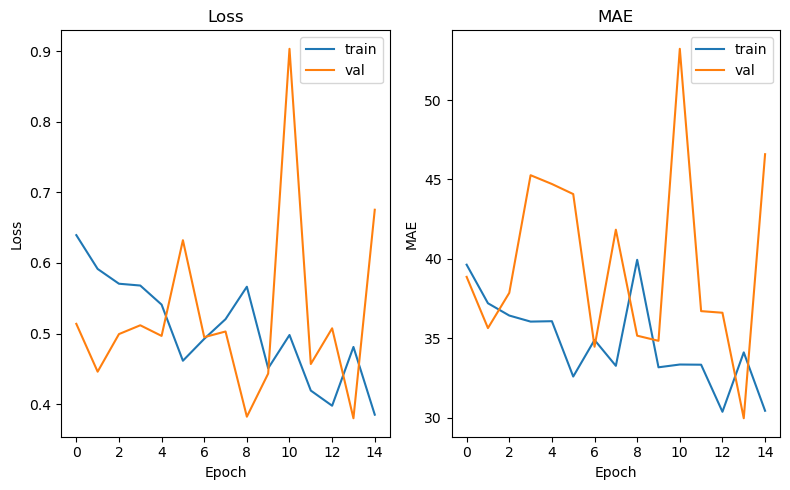

In [16]:
# visualize the training and val loss 
# visualize the training and val mae
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].plot(running_record['train_loss'], label='train')
ax[0].plot(running_record['val_loss'], label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_title('Loss')
# set x axis to be integer
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1].plot(running_record['train_mae'], label='train')
ax[1].plot(running_record['val_mae'], label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAE')
ax[1].legend()
ax[1].set_title('MAE')
# set x axis to be integer
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()